# Exp 016: Report Results for Grammar-Controlled Response Generation
This experiment creates descriptive statistics for the evaluation of different models to solve the problem.

In [3]:
import pandas as pd
import numpy as np
#from matplotlib import pyplot as plt
#from matplotlib.ticker import PercentFormatter
#import seaborn as sns
import random
#from scipy.stats import pearsonr

import sys
sys.path.append("../source")
from helpers import format_context, egp, get_prompt_task_2, get_prompt_task_3, get_preferred_nrs
#from evaluation import calculate_distinct_n, gpt_metrics

In [5]:
def get_aggs(results, by=['model', 'num_constraints'], distinct=False, aggs = []):
    distinct = {'responses0': calculate_distinct_n} if distinct else {}
    neg_const = {'num_categories_neg': ['mean']} if 'num_categories_neg' in results.columns else {}
    neg_const = {agg: ['mean'] for agg in aggs} if aggs else {}
    agg_col = "num_categories" if 'num_categories_neg' in results.columns else "num_constraints"
    aggs = results.groupby(by).agg({f'{by[1] if len(by)>1 else agg_col}_sat': ['mean', 'count'],
                                    **neg_const,
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in gpt_metrics.keys()}})
    return aggs

def plot_sat(res, col='num_constraints_sat', by='num_constraints', xlabel="Number of constraints", title="Relative amount of satisfied constraints", ylim=(0,1)):
    get_aggs(res, ["model", by], aggs=[col]).unstack(level=0)[col]['mean'].plot(kind='bar', rot=0)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.ylabel("Success Rate")
    plt.xlabel(xlabel)
    plt.ylim(ylim)
    plt.title(title)
    plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

def plot_distinct(single, name):
    x=single['responses0']['calculate_distinct_n']
    y=single['num_constraints_sat']['mean']
    ax = sns.scatterplot(x=x, y=y)
    ax.set_ylabel("Constraint Satisfaction")
    ax.set_xlabel("Distinct-2")
    ax.set_title(f"{name}: Single Constraint Satisfaction and Distinctiveness per Skill")
    for i, txt in enumerate(single.index):
        ax.annotate(txt, (x.iloc[i]+0.01, y.iloc[i]-0.02))
        pass  
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.axis(xmin=0.,xmax=1., ymin=0.,ymax=1.)
    plt.axvline(x=x.mean(), color='r', linestyle='--', label='Mean')
    plt.show()

def get_mean_distinct(model):
    return get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True)['responses0']['calculate_distinct_n'].mean()

def get_res(models):
    res = pd.DataFrame()
    
    for model in models:
        results = pd.read_json(f"../data/task1/{model}_eval.json")
        results['model']=model
        results = results[results['responses'].apply(len)>0]
        results['responses0'] = results['responses'].apply(lambda x: x[0])
        results['num_constraints'] = results['constraints'].apply(len)
        results['num_constraints_sat'] = results['positive_constraints'].apply(lambda x: np.count_nonzero(x)) / results['num_constraints']
        res = pd.concat([res, results])
    
    single_constraints = res[res['num_constraints']==1].copy()
    single_constraints['constraint'] = single_constraints['constraints'].apply(lambda x: x[0])
    return res, single_constraints

def plot_combined(res_melt, hue="Alpha", save=None, hue_order=None):
    g=sns.catplot(res_melt, kind="bar", x="Metric", hue=hue, y='Value', errorbar="ci", capsize=.1, hue_order = hue_order)

    g.fig.set_size_inches(10,4)
    new_labels = [label.get_text().replace(' ', '\n') for label in g.ax.get_xticklabels()]
    new_labels[0] = "Constraint\nSatisfaction"
    
    g.ax.set_xticklabels(new_labels)
    g.ax.set_ylabel("Constraint Satisfaction")
    g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
    ax2 = g.ax.twinx()
    ax2.set_ylim(g.ax.get_ylim())
    ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))
    ax2.set_ylabel('Response Quality')
    g.ax.axvline(x = .5, ymin = 0.01, ymax = 0.98, linestyle = "dotted",color="black") 
    
    if save: g.savefig(save)
    plt.show()

translation_dict = {
    'gpt35': 'GPT-3.5',
    'llama': 'Llama3',
    'llama-ft': 'Llama3 Fine-tune',
    'llama-FT-multi': 'Llama3 Fine-tune',
    'llama-decoding': 'Llama3 Decoding',
    'llama-decoding-2': 'Llama3 Decoding',
    'llama-ft-decoding': 'Llama3 Hybrid',
}
def translate_models(tab):
    tab.model = tab.model.map(translation_dict)

# Decoding Hyperparameter

In [23]:
models = ["decoding-0","decoding-09","decoding-095","decoding-099","decoding-0999","decoding-09999","decoding-1"]
res, _ = get_res(models)

In [24]:
get_aggs(res[res['num_constraints']>0], by=["model"])

num_constraints_sat       Appropriateness       Relevance  \
                              mean count            mean count      mean   
model                                                                      
decoding-0                0.357222   600            3.24   100      3.00   
decoding-09               0.503611   600            3.12   100      2.98   
decoding-095              0.551944   600            2.93   100      2.64   
decoding-099              0.633611   600            2.63   100      2.37   
decoding-0999             0.657500   600            2.24   100      2.02   
decoding-09999            0.651806   600            1.99   100      1.89   
decoding-1                0.654722   600            1.89   100      1.87   

                     Content Richness       Grammatical Correctness        
               count             mean count                    mean count  
model                                                                      
decoding-0       100             3.15   100                    4.86   100  
decoding-09      100             3.06   100                    4.76   100  
decoding-095     100             2.95   100                    4.73   100  
decoding-099     100             2.69   100                    4.57   100  
decoding-0999    100             2.45   100                    3.92   100  
decoding-09999   100             2.27   100                    3.51   100  
decoding-1       100             2.14   100                    2.96   100

In [25]:
res_melt = res[['model','num_constraints_sat']+list(gpt_metrics.keys())].melt(['model'], var_name='Metric', value_name='Value')
res_melt.loc[res_melt['Metric']!="num_constraints_sat",'Value'] /= 5
res_melt['Alpha'] = res_melt['model'].map({"decoding-0": "0.0",
                                          "decoding-09": "0.9",
                                          "decoding-095": "0.95",
                                          "decoding-099": "0.99",
                                          "decoding-0999": "0.999",
                                          "decoding-09999": "0.9999",
                                          "decoding-1": "1.0"})

/tmp/ipykernel_411243/1476805967.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(new_labels)
/tmp/ipykernel_411243/1476805967.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_411243/1476805967.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))


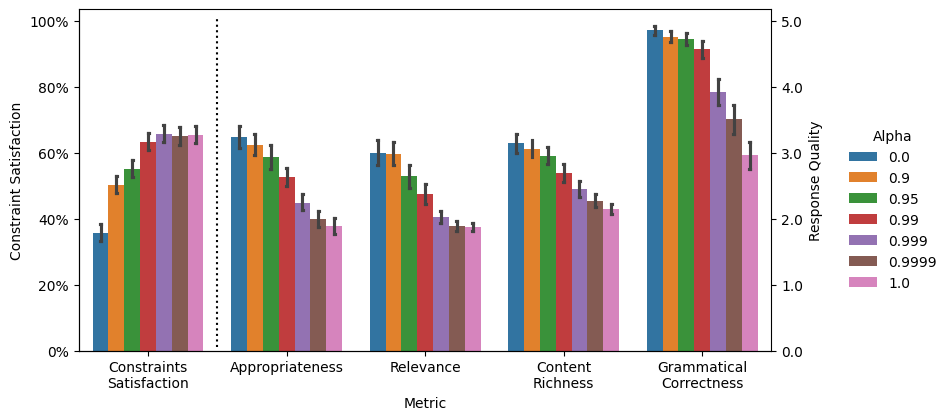

In [26]:
plot_combined(res_melt, save="../results/decoding_tuning.pdf")

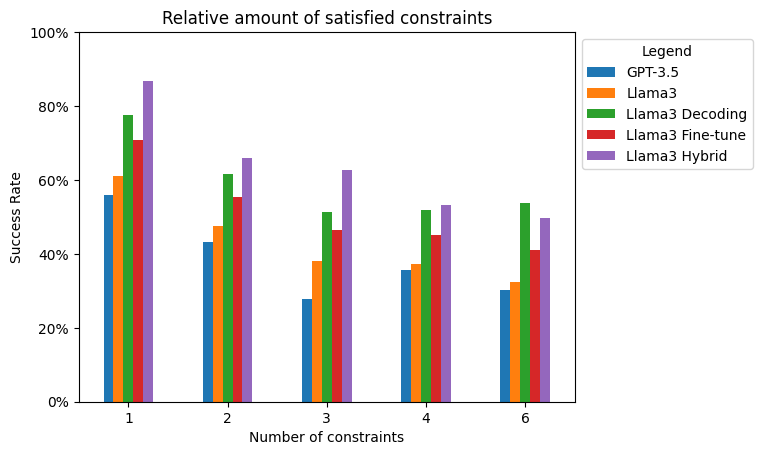

In [20]:
plot_sat(res)

# Task 1

In [6]:
models = ["gpt35", "llama", "llama-FT-multi", "llama-ft-decoding", "llama-decoding-2"]
res, single_constraints = get_res(models)
translate_models(res)
translate_models(single_constraints)

In [7]:
get_aggs(res, by=["model"])

NameError: name 'gpt_metrics' is not defined

/tmp/ipykernel_411243/1179202752.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(new_labels)
/tmp/ipykernel_411243/1179202752.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_411243/1179202752.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))


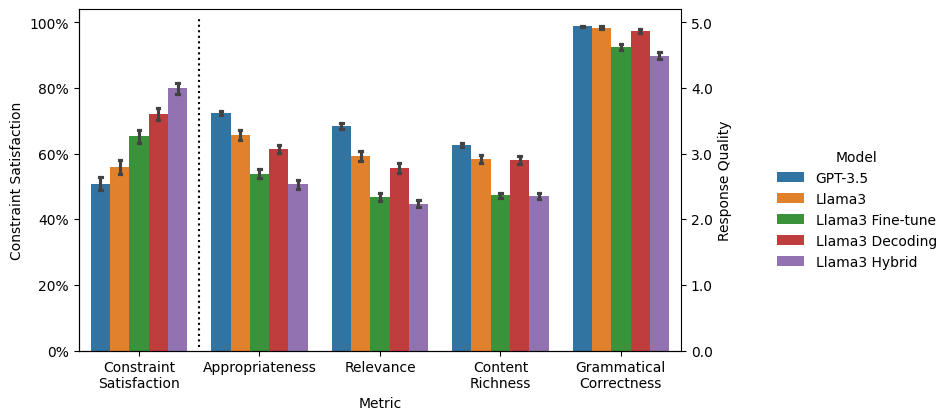

In [38]:
res_melt = res[['model','num_constraints_sat']+list(gpt_metrics.keys())].melt(['model'], var_name='Metric', value_name='Value')
res_melt.loc[res_melt['Metric']!="num_constraints_sat",'Value'] /= 5
res_melt.rename(columns={"model": 'Model'}, inplace=True)
plot_combined(res_melt, hue="Model", save="../results/task1.pdf", hue_order=['GPT-3.5', 'Llama3', 'Llama3 Fine-tune', 'Llama3 Decoding', 'Llama3 Hybrid'])

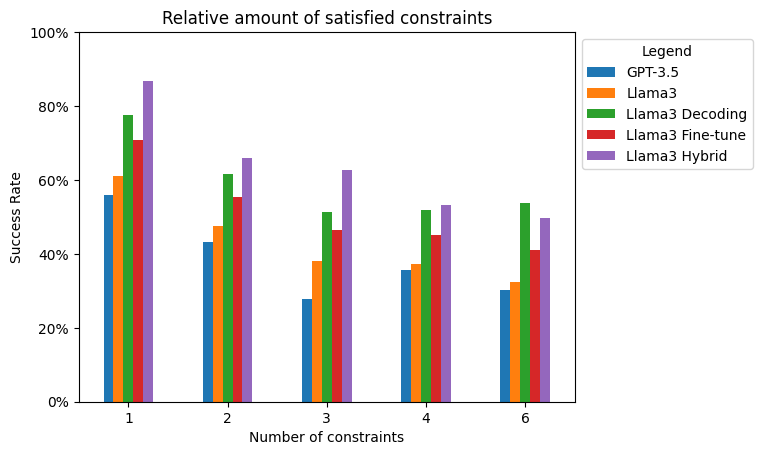

In [17]:
plot_sat(res)

## Qualitative evaluation

Pick a random test case and print answers from all models

In [22]:
models = list(res.model.unique())
case = res.loc[random.randint(0, max(res.index))]
print("=== DIALOG ===")
print(format_context(case.iloc[0]['context']))
constraints = case.iloc[0]['constraints']
print("=== CONSTRAINTS ===")
for statement in egp[egp['#'].isin(constraints)]['Can-do statement']:
    print(statement)
print("=== RESPONSES ===")
for model in models: 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses0']} ({responses.iloc[0]['num_constraints_sat']:.1%})")

=== DIALOG ===
A: Yeah. I think one year the winner was "It was a dark and story night." Which is funny because that's the real opening line of a kids book I read years ago.
B: That is funny and it doesnt seem that bad either lol, I bet I could do a better job at comming up with a bad oppening sentence.
A: whoops I meant "stormy" not "story." I'm a huge reader, but I've never read Winston Churchill's book that won the Nobel prize. How about you?
B: I didnt know that either, he must have some good litereature pieces then, you know that literature was like an olympic sport before 1952
=== CONSTRAINTS ===
Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.
Can use auxiliary 'do' + inverted subject after 'not only', to give focus.
=== RESPONSES ===
Model: GPT3.5
A: If literature was an Olympic sport, I would definitely be a gold medalist in reading! (50.0%)
Model: Llama3
A: Well, I would think t

## Quantitative Evaluation

In [7]:
get_aggs(single_constraints, ["model", "response_hit"])

num_constraints_sat       Appropriateness  \
                                              mean count            mean   
model             response_hit                                             
gpt35             0.0                     0.507586   725        3.658703   
                  1.0                     0.612414   725        3.696095   
llama             0.0                     0.606897   725        3.312849   
                  1.0                     0.615172   725        3.279793   
llama-FT-multi    0.0                     0.659310   725        2.705556   
                  1.0                     0.758621   725        2.818182   
llama-decoding-2  0.0                     0.766897   725        3.005319   
                  1.0                     0.786207   725        3.169231   
llama-ft-decoding 0.0                     0.855172   725        2.516854   
                  1.0                     0.881379   725        2.675127   

                                     Relevance       Content Richness        \
                               count      mean count             mean count   
model             response_hit                                                
gpt35             0.0            586  3.452218   586         3.083618   586   
                  1.0            589  3.528014   589         3.168081   589   
llama             0.0            179  2.972067   179         2.893855   179   
                  1.0            193  2.994819   193         2.860104   193   
llama-FT-multi    0.0            180  2.372222   180         2.333333   180   
                  1.0            187  2.411765   187         2.374332   187   
llama-decoding-2  0.0            188  2.734043   188         2.819149   188   
                  1.0            195  2.897436   195         2.933333   195   
llama-ft-decoding 0.0            178  2.286517   178         2.365169   178   
                  1.0            197  2.309645   197         2.390863   197   

                               Grammatical Correctness        
                                                  mean count  
model             response_hit                                
gpt35             0.0                         4.953925   586  
                  1.0                         4.955857   589  
llama             0.0                         4.932961   179  
                  1.0                         4.932642   193  
llama-FT-multi    0.0                         4.644444   180  
                  1.0                         4.673797   187  
llama-decoding-2  0.0                         4.898936   188  
                  1.0                         4.887179   195  
llama-ft-decoding 0.0                         4.573034   178  
                  1.0                         4.588832   197

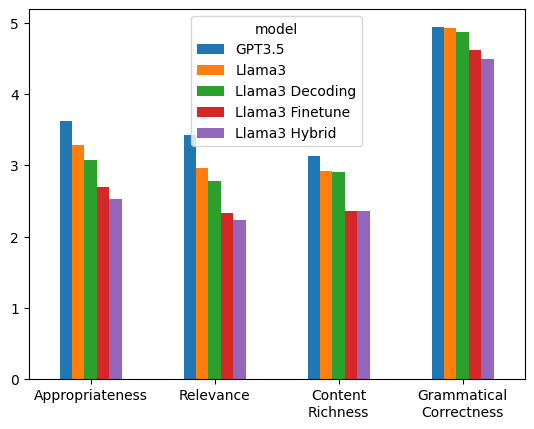

In [25]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in gpt_metrics.keys()}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

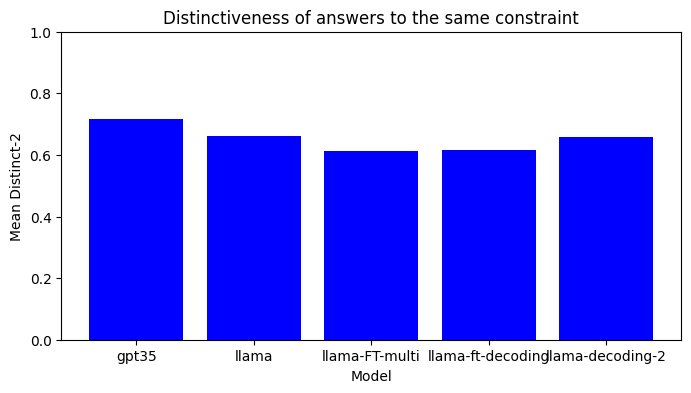

In [13]:
plt.figure(figsize=(8, 4))
plt.bar(models, [get_mean_distinct(model) for model in models], color='blue')
plt.xlabel('Model')
plt.ylabel('Mean Distinct-2')
plt.ylim(0,1)
plt.title('Distinctiveness of answers to the same constraint')
plt.show()

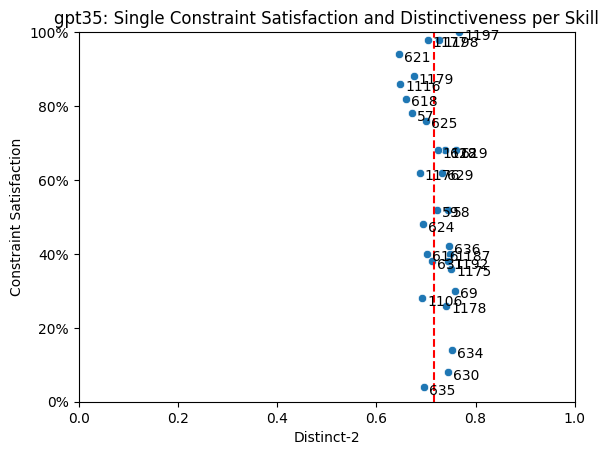

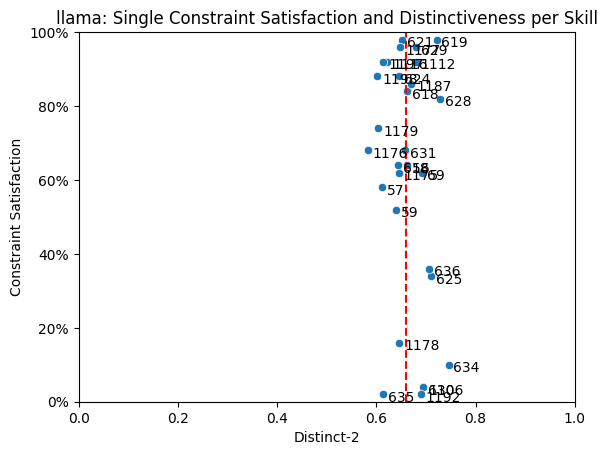

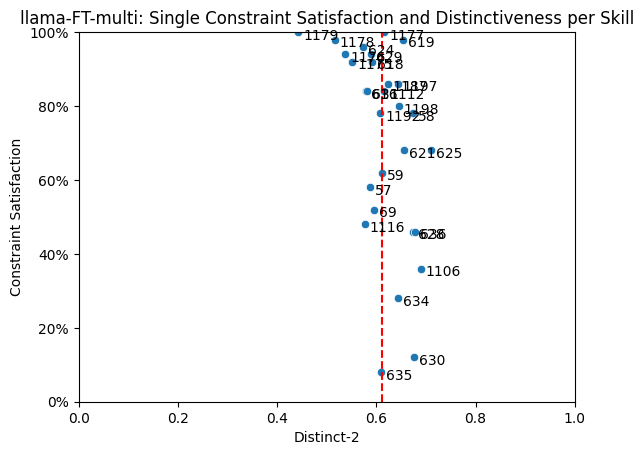

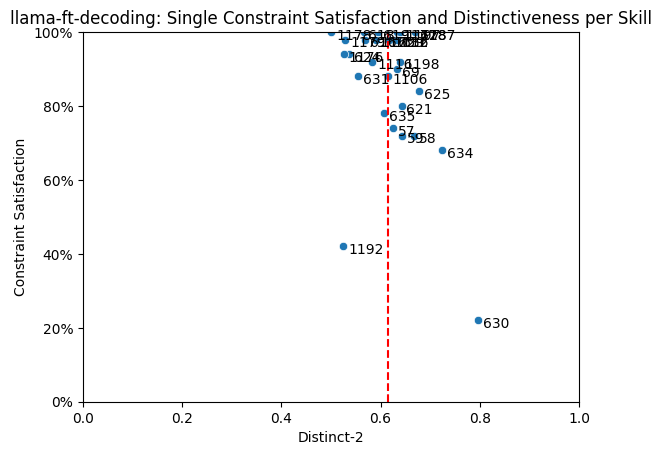

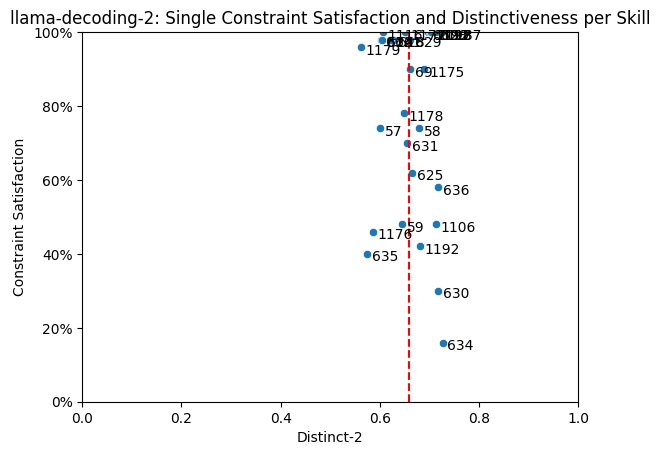

In [14]:
for model in models:
    plot_distinct(get_aggs(single_constraints[single_constraints['model']==model], ["constraint"], distinct=True), name=model)

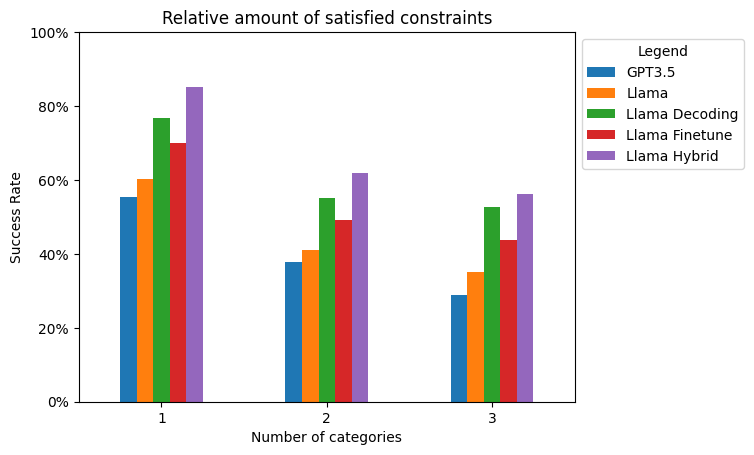

In [15]:
plot_sat(res, by="n_subcats", xlabel="Number of categories")

Report as a table

In [6]:
tab = get_aggs(res, ["model", "num_constraints"]).unstack(level=0)["num_constraints_sat"]['mean'].transpose()
tab['Mean'] = tab.iloc[:, :5].mean(axis=1)
tab.iloc[:, :6] = tab.iloc[:, :6].applymap(lambda x: f'{x*100:.1f}%')
tab.columns.name = "Number of constraints"
tab

/tmp/ipykernel_98628/2403409232.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab.iloc[:, :6] = tab.iloc[:, :6].applymap(lambda x: f'{x*100:.1f}%')
/tmp/ipykernel_98628/2403409232.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'model
GPT3.5             56.0%
Llama3             61.1%
Llama3 Decoding    77.7%
Llama3 Finetune    70.9%
Llama3 Hybrid      86.8%
Name: 1, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  tab.iloc[:, :6] = tab.iloc[:, :6].applymap(lambda x: f'{x*100:.1f}%')
/tmp/ipykernel_98628/2403409232.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'model
GPT3.5             43.2%
Llama3             47.5%
Llama3 Decoding    61.5%
Llama3 Finetune    55.5%
Llama3 Hybrid      66.0%
Name: 2, dtype: object' has dtype incompatible wi

Number of constraints,1,2,3,4,6,Mean
model,,,,,,
GPT3.5,56.0%,43.2%,27.7%,35.8%,30.2%,38.6%
Llama3,61.1%,47.5%,38.0%,37.2%,32.3%,43.2%
Llama3 Decoding,77.7%,61.5%,51.3%,51.7%,53.8%,59.2%
Llama3 Finetune,70.9%,55.5%,46.3%,45.0%,41.2%,51.8%
Llama3 Hybrid,86.8%,66.0%,62.7%,53.2%,49.8%,63.7%


In [7]:
latex_table = tab.to_latex(escape=True)
print(latex_table)

\begin{tabular}{lllllll}
\toprule
Number of constraints & 1 & 2 & 3 & 4 & 6 & Mean \\
model &  &  &  &  &  &  \\
\midrule
GPT3.5 & 56.0\% & 43.2\% & 27.7\% & 35.8\% & 30.2\% & 38.6\% \\
Llama3 & 61.1\% & 47.5\% & 38.0\% & 37.2\% & 32.3\% & 43.2\% \\
Llama3 Decoding & 77.7\% & 61.5\% & 51.3\% & 51.7\% & 53.8\% & 59.2\% \\
Llama3 Finetune & 70.9\% & 55.5\% & 46.3\% & 45.0\% & 41.2\% & 51.8\% \\
Llama3 Hybrid & 86.8\% & 66.0\% & 62.7\% & 53.2\% & 49.8\% & 63.7\% \\
\bottomrule
\end{tabular}



In [8]:
def get_avg_wpm(model):
    times = pd.read_json(f"../data/task1/{model}-time.json")
    return f"{int((times['responses'].apply(lambda x: len(x[0].split())) / times['time'] * 60).mean().round(0))} wpm"

In [9]:
{model: get_avg_wpm(model) for model in models}

{'gpt35': '1650 wpm',
 'llama': '695 wpm',
 'llama-FT-multi': '634 wpm',
 'llama-ft-decoding': '344 wpm',
 'llama-decoding-2': '524 wpm'}

In [29]:
tab = pd.DataFrame()
for ind in gpt_metrics.keys():
    tab[ind] = get_aggs(single_constraints, ["model"])[ind]['mean']

tab['Distinct-2'] = [get_mean_distinct(model) for model in res.model.unique()]
tab['Inference'] = [get_avg_wpm(model) for model in models]
tab.iloc[:, :5] = tab.iloc[:, :5].round(2)
tab.columns.name = ""
tab

,Appropriateness,Relevance,Content Richness,Grammatical Correctness,Distinct-2,Inference
model,,,,,,
GPT3.5,3.68,3.49,3.13,4.95,0.72,1650 wpm
Llama3,3.30,2.98,2.88,4.93,0.66,695 wpm
Llama3 Decoding,3.09,2.82,2.88,4.89,0.61,634 wpm
Llama3 Finetune,2.76,2.39,2.35,4.66,0.61,344 wpm
Llama3 Hybrid,2.60,2.30,2.38,4.58,0.66,524 wpm


In [30]:
latex_table = tab.to_latex(escape=True)
print(latex_table)

\begin{tabular}{lrrrrrl}
\toprule
{} &  Appropriateness &  Relevance &  Content Richness &  Grammatical Correctness &  Distinct-2 & Inference \\
model           &                  &            &                   &                          &             &           \\
\midrule
GPT3.5          &             3.68 &       3.49 &              3.13 &                     4.95 &        0.72 &  1650 wpm \\
Llama3          &             3.30 &       2.98 &              2.88 &                     4.93 &        0.66 &   695 wpm \\
Llama3 Decoding &             3.09 &       2.82 &              2.88 &                     4.89 &        0.61 &   634 wpm \\
Llama3 Finetune &             2.76 &       2.39 &              2.35 &                     4.66 &        0.61 &   344 wpm \\
Llama3 Hybrid   &             2.60 &       2.30 &              2.38 &                     4.58 &        0.66 &   524 wpm \\
\bottomrule
\end{tabular}



/tmp/ipykernel_95079/921133908.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = tab.to_latex(escape=True)


## Constraint difficulty

In [7]:
def get_best_singles(models):
    best = res[res['model'].isin(models)].copy()
    best['combined'] = best.apply(lambda row: list(zip(row['constraints'], row['positive_constraints'])), axis=1)
    singles = best[['combined', 'num_constraints', 'model']].explode('combined').reset_index(drop=True)
    singles[['constraint', 'satisfied']] = singles['combined'].apply(pd.Series)
    singles.drop(columns="combined")
    singles = singles[~singles.constraint.isin([1106,1112,1116])]
    singles['num_constraints'] = singles['num_constraints'] > 1
    singles['Category'] = singles['constraint'].map(egp['SubCategory']).apply(lambda x: x.capitalize())
    return best, singles

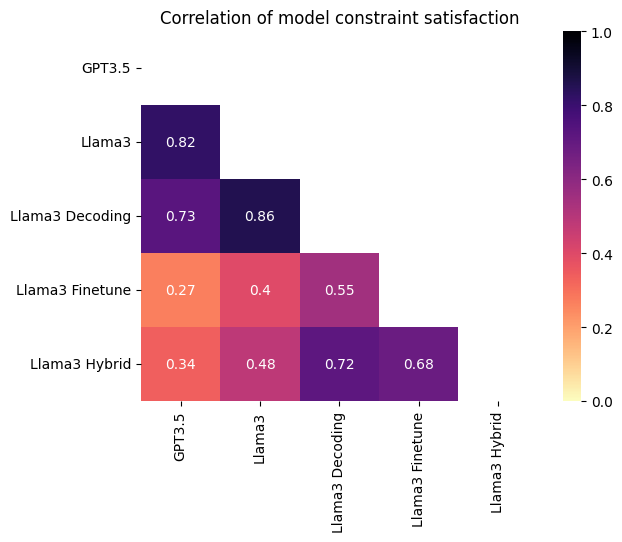

In [8]:
models = list(translation_dict.values())
best, singles = get_best_singles(models)
constraint_model = singles.groupby(["model", "constraint"]).agg({"satisfied": "mean"})
corrs = constraint_model.reset_index().pivot(index="constraint", columns="model", values="satisfied").corr()
heatmap = sns.heatmap(corrs, vmin=0, vmax=1, annot=True, mask=np.triu(np.ones_like(corrs, dtype=bool)), cmap=sns.color_palette("magma_r", as_cmap=True))
heatmap.set(xlabel=None, ylabel=None, title="Correlation of model constraint satisfaction")
plt.savefig("../results/constraint_correlation.pdf", bbox_inches="tight")
plt.show()

In [9]:
constraint_sat = singles.groupby(["constraint", "num_constraints"]).agg({"satisfied": "mean"}).reset_index().pivot(index="constraint", columns=["num_constraints"])['satisfied']
pearsonr(constraint_sat[True], constraint_sat[False])

PearsonRResult(statistic=0.8869146985352134, pvalue=1.6028894883960743e-09)

In [35]:
models = ["GPT3.5", "Llama3", "Llama3 Decoding"]
best, singles = get_best_singles(models)
constraint_model = singles.groupby(["model", "constraint"]).agg({"satisfied": "mean"})

In [45]:
models = ["GPT3.5", "Llama3", "Llama3 Decoding", "Llama3 Finetune", "Llama3 Hybrid"]
_, all_models = get_best_singles(models)
df = all_models.groupby(["model", "constraint"]).agg({"satisfied": "mean"}).reset_index().pivot(index="constraint",columns="model",values="satisfied")
df_percentage = df.applymap(lambda x: f"{x*100:.1f}%")
print(df_percentage.to_latex().replace("%","\%").replace("\\\n", "\\ \hline\n"))

\begin{tabular}{llllll}
\toprule
model & GPT3.5 & Llama3 & Llama3 Decoding & Llama3 Finetune & Llama3 Hybrid \\ \hline
constraint &  &  &  &  &  \\ \hline
\midrule
57 & 86.5\% & 62.7\% & 71.0\% & 25.4\% & 47.2\% \\ \hline
58 & 43.3\% & 46.1\% & 54.4\% & 46.7\% & 54.4\% \\ \hline
59 & 31.2\% & 35.1\% & 33.2\% & 37.1\% & 45.0\% \\ \hline
69 & 23.8\% & 40.5\% & 51.0\% & 27.1\% & 41.4\% \\ \hline
616 & 31.9\% & 44.0\% & 86.8\% & 85.7\% & 86.8\% \\ \hline
618 & 61.4\% & 77.2\% & 93.1\% & 78.2\% & 90.1\% \\ \hline
619 & 68.9\% & 87.4\% & 82.5\% & 95.1\% & 89.3\% \\ \hline
621 & 88.5\% & 90.8\% & 87.4\% & 39.1\% & 52.9\% \\ \hline
624 & 37.9\% & 76.7\% & 84.5\% & 83.5\% & 83.5\% \\ \hline
625 & 62.6\% & 37.4\% & 62.6\% & 67.0\% & 70.3\% \\ \hline
628 & 53.8\% & 67.7\% & 92.5\% & 30.1\% & 91.4\% \\ \hline
629 & 62.5\% & 75.0\% & 82.3\% & 88.5\% & 88.5\% \\ \hline
630 & 4.9\% & 8.6\% & 28.4\% & 12.3\% & 16.0\% \\ \hline
631 & 31.5\% & 58.4\% & 60.7\% & 76.4\% & 62.9\% \\ \hline
634 & 8.4\% & 7.

/tmp/ipykernel_1424350/3413195023.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_percentage = df.applymap(lambda x: f"{x*100:.1f}%")


In [11]:
max_satisfaction = constraint_model.groupby("constraint").agg({"satisfied": "max"}).reset_index()

In [12]:
models = ["Llama3 Decoding"]
best, singles = get_best_singles(models)

In [13]:
constraint_sat = singles.groupby(["constraint", "num_constraints"]).agg({"satisfied": "mean"}).reset_index().pivot(index="constraint", columns=["num_constraints"])['satisfied']
pearsonr(constraint_sat[True], constraint_sat[False])

PearsonRResult(statistic=0.8017944020158778, pvalue=8.476962998617596e-07)

Check distictiveness

In [14]:
dists = get_aggs(single_constraints[single_constraints['model'].isin(models)], ["constraint"], distinct=True)
pearsonr(dists[("num_constraints_sat","mean")], dists[("responses0", "calculate_distinct_n")])

PearsonRResult(statistic=-0.12101661156287417, pvalue=0.5317524498995851)

In [15]:
print([pearsonr(dists[("num_constraints_sat","mean")], dists[(metric, "mean")]) for metric in gpt_metrics.keys()])

[PearsonRResult(statistic=0.18109055525412246, pvalue=0.34716088626944897), PearsonRResult(statistic=0.2525701529049376, pvalue=0.18621663158026755), PearsonRResult(statistic=0.005274805281769003, pvalue=0.9783350494512241), PearsonRResult(statistic=0.09365027797415522, pvalue=0.6289518122312737)]


In [16]:
def describe(x):
    skill = egp[egp['#']==int(x.get_text())].iloc[0]
    x.set_text(str(skill['#']) + ": " + skill['guideword'][skill['guideword'].index(':')+2:].capitalize())
    return x

/tmp/ipykernel_1424350/2051065043.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_1424350/2051065043.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels([describe(label) for label in g.ax.get_xticklabels()], rotation=45, ha='right')


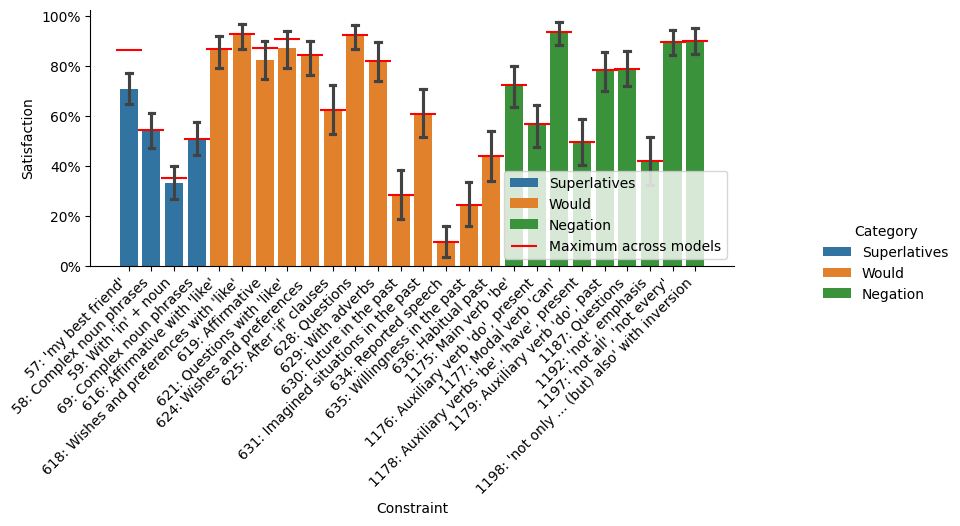

In [17]:
g=sns.catplot(singles, kind="bar", x="constraint", y='satisfied', hue="Category", dodge=False, errorbar="ci", capsize=.25, legend=True)
g.fig.set_size_inches(10,3)
#g.ax.set_title("Satisfaction by Constraint")
g.ax.set_ylabel("Satisfaction")
g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
g.ax.set_xlabel("Constraint")
g.ax.set_xticklabels([describe(label) for label in g.ax.get_xticklabels()], rotation=45, ha='right')

ax = g.facet_axis(0, 0)
ax.scatter(max_satisfaction.index, max_satisfaction['satisfied'], color='red', marker='_', s=350, label="Maximum across models")
ax.legend()
g.savefig("../results/constraint_difficulty.pdf")
plt.show()

In [24]:
singles.groupby("constraint").agg({"satisfied": "mean"}).sort_values("satisfied")

,satisfied
constraint,
634,0.096386
635,0.242105
630,0.283951
59,0.331683
1192,0.419048
636,0.440000
1178,0.495327
69,0.509524
58,0.544444


# Task 2

In [39]:
def categories_satisfied(row, type='positive'):
    df = pd.DataFrame({'score': row[f'{type}_constraints'], 'category': row[f'{type}_categories']})
    return np.mean(df.groupby("category").agg({"score": lambda x: np.count_nonzero(x)>0})['score'])

In [ ]:
models = ["gpt35", "llama", "llama-ft", "llama-decoding", "llama-ft-decoding"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task2/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]

    results['num_constraints'] = results['positive_constraints'].apply(len)
    results['num_categories'] = results['categories'].apply(len)
    results['num_categories_sat'] = results.apply(categories_satisfied, axis=1)
    results['num_categories_neg'] = results.apply(categories_satisfied, axis=1, args=['negative'])
    res = pd.concat([res, results])
translate_models(res)

Number of constraints

<Axes: >

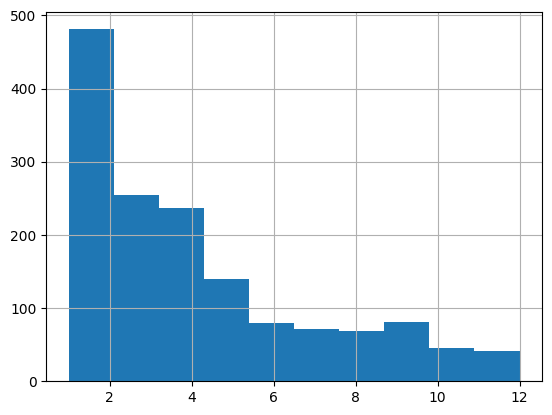

In [37]:
results['num_constraints'].hist()

## Qualitative Evaluation

In [5]:
case = res.loc[random.randint(0, max(res.index))]
msg = get_prompt_task_2(case.copy().iloc[0])['messages'][0]['content']
print(msg)

print("=== RESPONSES ===")
for model in res.model.unique(): 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses'][0]} ({responses.iloc[0]['num_categories_sat']:.0%}/{responses.iloc[0]['num_categories_neg']:.0%})")

Given the dialog, write a possible next turn of A that preferably uses the following grammatical items in the response:
- superlatives on CEFR level A2 (FORM/USE: COMPLEX NOUN PHRASES; FORM/USE: WITH 'IN' + NOUN)
- would on CEFR level B2 (USE: HABITUAL PAST)
Dialog:
A: I know right! I wouldn't either if they pay me in the millions or a potential of it haha and I didnt know that about the Jordans, I did know that Nike offered Lebron 90 million, shortly after reebok offered him 10 million that Lebron rejected! Who rejects 10 mil! Oh my Lordy!
B: Wow! It's a good thing he rejected though. He earned himself 80 million! Yeah I guess Jordan wore his Jordans anyway, because NIKE was willing to pay the fine each time! That worked well for them, I think!
A: I know!! Its almost like he expected it, but when you are that good I guess you expect it, its good business! I wouldn't have rejected probably unless I was coached into it. It makes sense though
B: Yeah I definitely wouldn't have rejected t

## Quantitative evaluation

In [ ]:

def plot_combined(res_melt, hue="Alpha", save=None):
    g=sns.catplot(res_melt, kind="bar", x="Metric", hue=hue, hue_order=['GPT-3.5', 'Llama3', 'Llama3 Fine-tune', 'Llama3 Decoding', 'Llama3 Hybrid'], y='Value', errorbar="ci", capsize=.1)
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(0.42, 0.95), ncol=5, title=None, frameon=False,
    )
    g.fig.set_size_inches(10,4)
    new_labels = [label.get_text().replace(' ', '\n') for label in g.ax.get_xticklabels()]
    new_labels[0] = "Constraint\nSatisfaction"
    g.ax.set_xticklabels(new_labels)
    g.ax.set_ylabel("Constraint Satisfaction")
    g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
    ax2 = g.ax.twinx()
    ax2.set_ylim(g.ax.get_ylim())
    ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))
    ax2.set_ylabel('Response Quality')
    g.ax.axvline(x = .5, ymin = 0.01, ymax = 0.98, linestyle = "dotted",color="black") 
    
    if save: g.savefig(save)
    plt.show()

/tmp/ipykernel_411243/1179202752.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(new_labels)
/tmp/ipykernel_411243/1179202752.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_411243/1179202752.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))


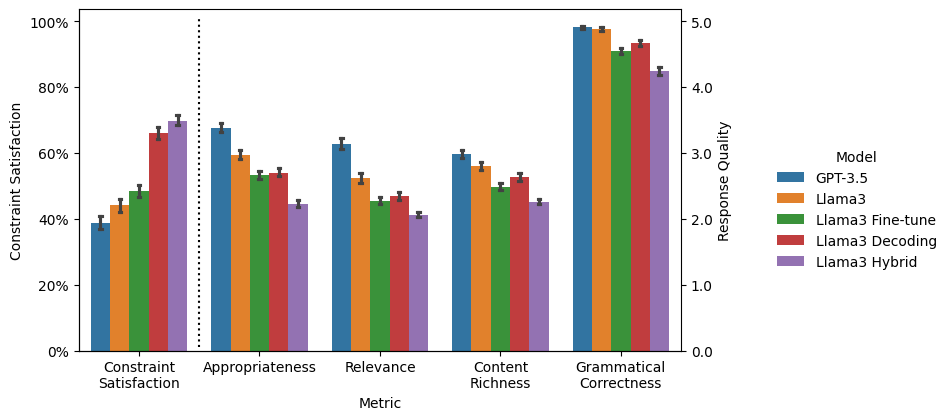

In [41]:
res_melt = res[['model','num_categories_sat']+list(gpt_metrics.keys())].melt(['model'], var_name='Metric', value_name='Value')
res_melt.loc[res_melt['Metric']!="num_categories_sat",'Value'] /= 5
res_melt.rename(columns={"model": 'Model'}, inplace=True)
plot_combined(res_melt, hue="Model", save="../results/task2.pdf", )


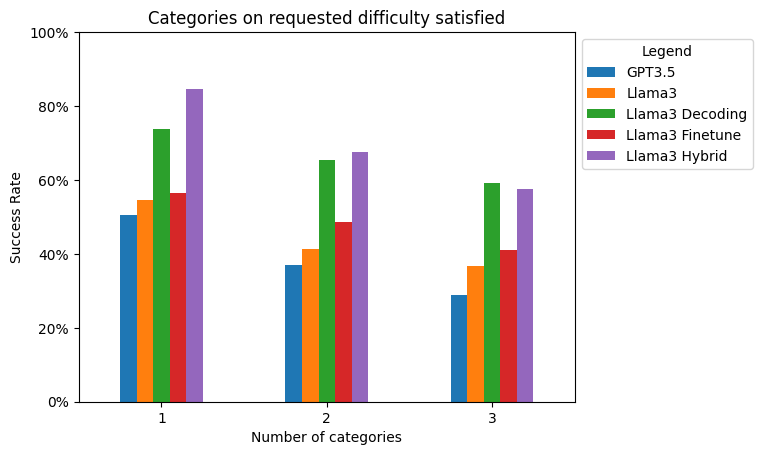

In [18]:
plot_sat(res, col='num_categories_sat', by='num_categories', xlabel="Number of categories", title="Categories on requested difficulty satisfied")

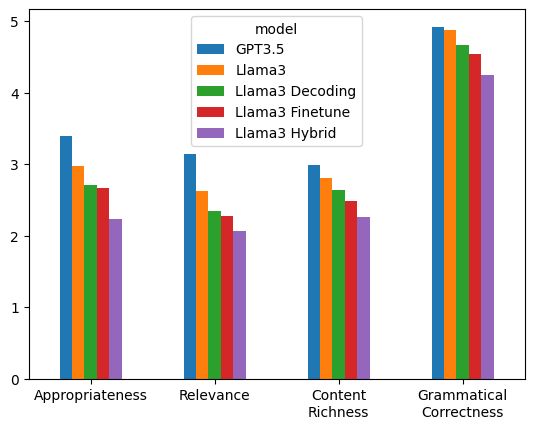

In [19]:
df =res.groupby(['model']).agg({**{col: 'mean' for col in ['Appropriateness', 'Relevance', 'Content Richness', 'Grammatical Correctness']}})
ax=df.transpose().plot(kind='bar', rot=0)
ax.set_xticklabels([l.get_text().replace(" ", "\n") for l in ax.get_xticklabels()])
plt.show()

In [25]:
get_aggs(res, by=["model"], aggs=['num_categories_neg'])

num_categories_sat       num_categories_neg Appropriateness  \
                              mean count               mean            mean   
model                                                                         
GPT3.5                    0.387889  1500           0.046884           3.388   
Llama3                    0.442000  1500           0.050820           2.976   
Llama3 Decoding           0.661444  1500           0.077371           2.704   
Llama3 Finetune           0.486111  1500           0.079814           2.662   
Llama3 Hybrid             0.698889  1500           0.061646           2.232   

                      Relevance       Content Richness        \
                count      mean count             mean count   
model                                                          
GPT3.5            500     3.144   500            2.984   500   
Llama3            500     2.626   500            2.810   500   
Llama3 Decoding   500     2.348   500            2.634   500   
Llama3 Finetune   500     2.276   500            2.492   500   
Llama3 Hybrid     500     2.066   500            2.260   500   

                Grammatical Correctness        
                                   mean count  
model                                          
GPT3.5                            4.916   500  
Llama3                            4.882   500  
Llama3 Decoding                   4.672   500  
Llama3 Finetune                   4.544   500  
Llama3 Hybrid                     4.246   500

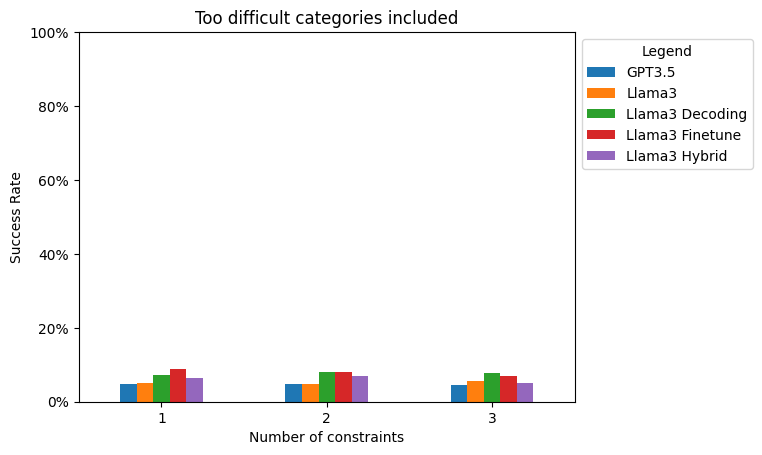

In [20]:
plot_sat(res, col='num_categories_neg', by='num_categories', title="Too difficult categories included")

# Task 3

In [67]:
models = ["gpt35", "llama", "llama-decoding", "llama-ft","llama-ft-decoding"]
res = pd.DataFrame()

for model in models:
    results = pd.read_json(f"../data/task3/{model}_eval.json")
    results['model']=model
    results = results[results['responses'].apply(len)>0]

    results['level_sat'] = results['positive_constraints'].apply(np.mean)
    results['level_neg'] = results['negative_constraints'].apply(np.mean)
    results['diff'] = results['level_sat'] - results['level_neg']
    res = pd.concat([res, results])

translate_models(res)

In [68]:
case = res.loc[random.sample(list(res.index), k=1)[0]]
msg = get_prompt_task_3(case.copy().iloc[0])['messages'][0]['content']
print(msg)

print("=== RESPONSES ===")
for model in res.model.unique(): 
    print(f"Model: {model}")
    responses = case[case['model']==model]
    if not len(responses): continue
    print(f"{responses.iloc[0]['responses'][0]} ({responses.iloc[0]['level_sat']:.0%}/{responses.iloc[0]['level_neg']:.0%})")

Given the dialog, write a possible next turn of A that uses grammatical items on CEFR level B1.
Dialog:
A: I like that the movie is framed with Nick's time in rehab, telling the story of Gatsby.
B: yeah exactly! I liked that it was told from outside point of view because if it were from Gatsby it would be like "why doesn't she like my epic parties?????"" lmao
A: Apparently the green light is an important example of symbolism
B: Gatsby's version would be boring. He would spend all of the time describing how great the parties are and how expensive everything is.

=== RESPONSES ===
Model: GPT3.5
A: Yeah, I agree. It's interesting how the green light represents Gatsby's hopes and dreams for the future. (0%/0%)
Model: Llama3
A: Yeah, I think that's what makes the movie interesting, it's not just about Gatsby's wealth and parties, it's about the themes and characters. (0%/0%)
Model: Llama3 Decoding
A: Yeah, I didn't like that about Gatsby's book. It felt very one-sided. (0%/0%)
Model: Llama3

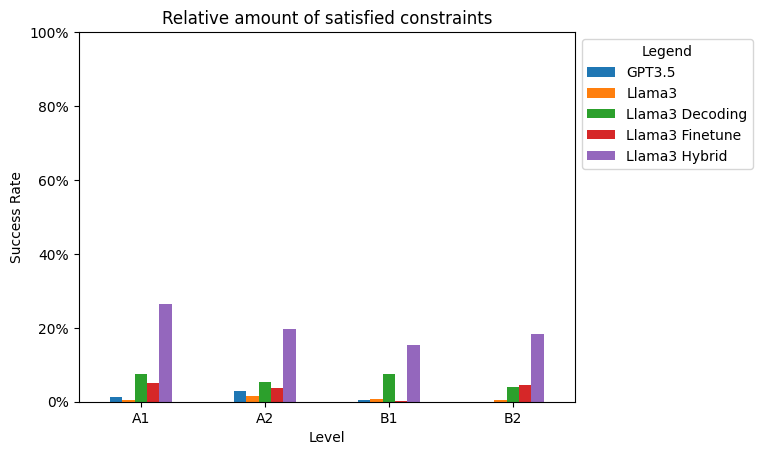

In [41]:
plot_sat(res, col="level_sat", by="level", xlabel="Level")

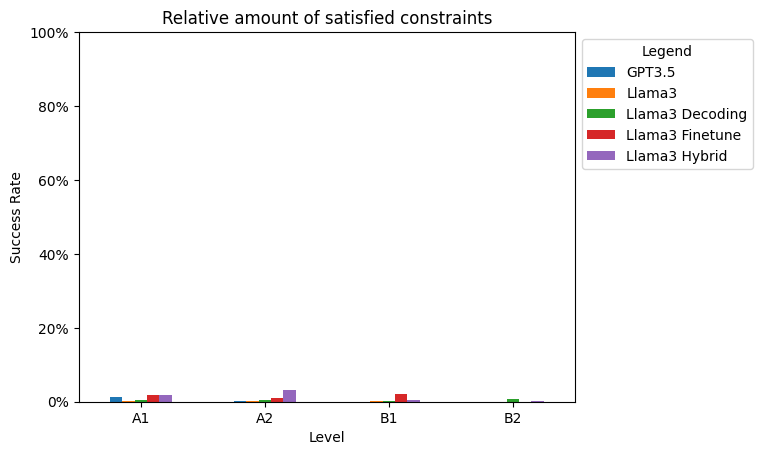

In [42]:
plot_sat(res, col="level_neg", by="level", xlabel="Level")

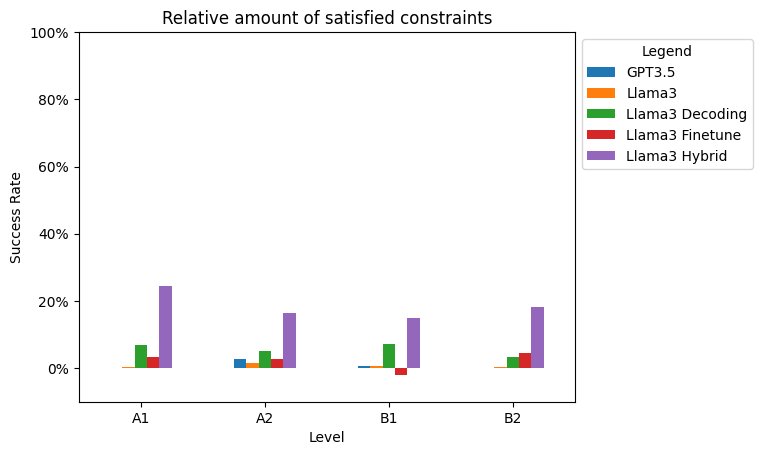

In [43]:
plot_sat(res, col="diff", by="level", xlabel="Level", ylim=(-0.1,1))

/tmp/ipykernel_3005845/3193045787.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])


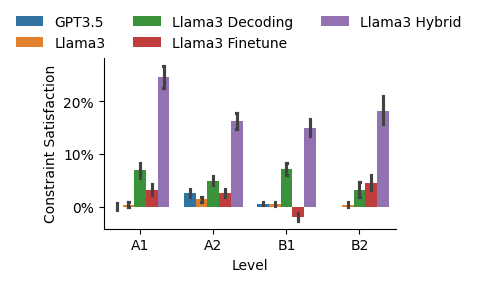

In [66]:
def plot_combined(res_melt, hue, save=None):
    g=sns.catplot(res_melt, kind="bar", x="level", hue=hue, y='Value', errorbar="ci", capsize=.025)
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(0.42, 0.95), ncol=3, title=None, frameon=False,
    )
    g.fig.set_size_inches(5,2)
    g.ax.set_xlabel("Level")
    g.ax.set_ylabel("Constraint Satisfaction")
    g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
    
    if save: g.savefig(save)
    plt.show()

res_melt = res[['model', 'level', 'diff']].melt(['model','level'], var_name='Metric', value_name='Value')
#res_melt.loc[res_melt['Metric']!="diff",'Value'] /= 5
res_melt.rename(columns={"model": 'Model'}, inplace=True)
plot_combined(res_melt, hue="Model", save="../results/task3.pdf")

/tmp/ipykernel_3005845/341367544.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(new_labels)
/tmp/ipykernel_3005845/341367544.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
/tmp/ipykernel_3005845/341367544.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))


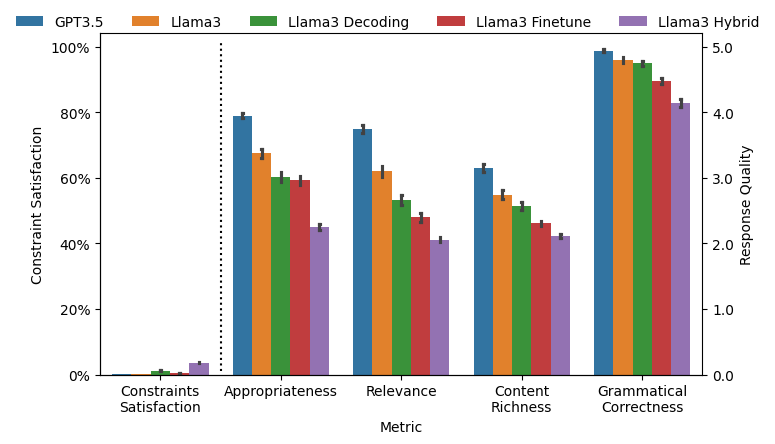

In [69]:

def plot_combined(res_melt, hue="Alpha", save=None):
    g=sns.catplot(res_melt, kind="bar", x="Metric", hue=hue, y='Value', errorbar="ci", capsize=.025)
    sns.move_legend(
        g, "lower center",
        bbox_to_anchor=(0.42, 0.95), ncol=5, title=None, frameon=False,
    )
    g.fig.set_size_inches(10,4)
    new_labels = [label.get_text().replace(' ', '\n') for label in g.ax.get_xticklabels()]
    new_labels[0] = "Constraints\nSatisfaction"
    g.ax.set_xticklabels(new_labels)
    g.ax.set_ylabel("Constraint Satisfaction")
    g.ax.set_yticklabels(['{:.0%}'.format(y) for y in g.ax.get_yticks()])
    ax2 = g.ax.twinx()
    ax2.set_ylim(g.ax.get_ylim())
    ax2.set_yticklabels(np.round(g.ax.get_yticks()*5,0))
    ax2.set_ylabel('Response Quality')
    g.ax.axvline(x = .5, ymin = 0.01, ymax = 0.98, linestyle = "dotted",color="black") 
    
    if save: g.savefig(save)
    plt.show()

res_melt = res[['model','diff']+list(gpt_metrics.keys())].melt(['model'], var_name='Metric', value_name='Value')
res_melt.loc[res_melt['Metric']!="num_categories_sat",'Value'] /= 5
res_melt.rename(columns={"model": 'Model'}, inplace=True)
plot_combined(res_melt, hue="Model", save="../results/task2.pdf", )


In [76]:
def get_aggs(results, by=['model', 'num_constraints'], distinct=False, aggs = []):
    distinct = {'responses0': calculate_distinct_n} if distinct else {}
    neg_const = {'num_categories_neg': ['mean']} if 'num_categories_neg' in results.columns else {}
    neg_const = {agg: ['mean'] for agg in aggs} if aggs else {}
    agg_col = "num_categories" if 'num_categories_neg' in results.columns else "num_constraints"
    agg_col = "level" if 'level' in results.columns else agg_col
    aggs = results.groupby(by).agg({f'{by[1] if len(by)>1 else agg_col}_sat': ['mean', 'count'],
                                    **neg_const,
                                    **distinct,
                                    **{col: ['mean', 'count'] for col in gpt_metrics.keys()}})
    return aggs
get_aggs(res, ["model"])#.unstack(level=0)["num_constraints_sat"]['mean'].transpose()

level_sat       Appropriateness       Relevance        \
                     mean count            mean count      mean count   
model                                                                   
GPT3.5           0.012580  1000           3.950   500     3.748   500   
Llama3           0.008066  1000           3.374   500     3.102   500   
Llama3 Decoding  0.062293  1000           3.008   500     2.658   500   
Llama3 Finetune  0.034098  1000           2.966   500     2.402   500   
Llama3 Hybrid    0.197471  1000           2.250   500     2.054   500   

                Content Richness       Grammatical Correctness        
                            mean count                    mean count  
model                                                                 
GPT3.5                     3.152   500                   4.942   500  
Llama3                     2.740   500                   4.798   500  
Llama3 Decoding            2.574   500                   4.748   500  
Llama3 Finetune            2.306   500                   4.486   500  
Llama3 Hybrid              2.108   500                   4.144   500